# Segment and quantify puncta (Setup)

This is a setup notebook for adjusting parameters for [run_puncta_analysis.ipynb](run_puncta_analysis.ipynb).

Run this notebook cell-by-cell and follow the instructions.

## Documentation

[Details of the puncta segmentation procedure](../docs/puncta_segmentation.md)

[Table summarizing all parameters that are adjusted in this notebook](../docs/parameters.md#list-of-parameters-for-puncta-segmentation-and-analysis)


## Requirements

- A **folder with images** to analyze. All z-layers and channels for a specific sample must be combined into a single file. To combine z-layers and channels, use the [setup_images_to_stack.ipynb](setup_images_to_stack.ipynb) and [run_images_to_stack.ipynb](run_images_to_stack.ipynb) notebooks.

or 

- A  **folder with images** generated by [run_roi_segmentation.ipynb](run_roi_segmentation.ipynb) or [run_roi_segmentation.py](../scripts/run_roi_segmentation.py); the images must contain raw image channels + ROI segmentation mask

<hr style="height:2px;">

## Config

<hr style="height:2px;">

### The following code imports and declares functions used for the processing:

In [1]:
#################################
#  Don't modify the code below  #
#################################

import json
import os
import numpy as np
import intake_io
from skimage.feature import blob_log
from skimage.segmentation import watershed
from scipy import ndimage
import pylab as plt
from skimage import io
from skimage import filters
from skimage import feature
from skimage import restoration
from skimage import morphology as morph
from tqdm import tqdm
from skimage.segmentation import watershed, mark_boundaries
from skimage.util import map_array

from am_utils.utils import walk_dir
from punctatools.lib.segment import calculate_background_image, centers_to_markers, threshold_puncta, filter_laplace
from punctatools.lib.utils import show_dataset, display_blobs
from punctatools.lib.utils import crop_dataset, convert_params

%matplotlib inline

2022-07-19 14:30:57,227 [INFO] WRITING LOG OUTPUT TO /home/amedyukh/.cellpose/run.log


In [2]:
def show_imgs(imgs, s=4):
    fig, ax = plt.subplots(1, len(imgs), figsize=(len(imgs)*s, s))
    for i in range(len(imgs)):
        plt.sca(ax[i])
        io.imshow(imgs[i].max(0))


<hr style="height:2px;">

## Set up the data to segment

<hr style="height:2px;">

`input_dir`: A folder with images to analyze. If ROI segmentation was done, set this to the `output_dir` of the ROI segmentation. 

`roi_segmentation`: Set to `True` if the ROI segmentation was done and the last channel of the images in the `input_dir` contains the segmentation mask

`output_dir`: output directory for the puncta analysis results

In [3]:
input_dir = "/research/sharedresources/cbi/common/Anna/test_data/punctatools/roi"
roi_segmentation = True
output_dir = "../test_output/puncta_analysis"

### The following code lists all image files in the input directory:

In [4]:
#################################
#  Don't modify the code below  #
#################################

print(rf"Input directory: {input_dir}")
if not roi_segmentation:
    print('No cell segmentation provided')
samples = walk_dir(input_dir)

print(f'\n{len(samples)} images were found:')
for i in range(len(samples)):
    print(i, samples[i])

Input directory: /research/sharedresources/cbi/common/Anna/test_data/punctatools/roi

7 images were found:
0 /research/sharedresources/cbi/common/Anna/test_data/punctatools/roi/08102021_GFPempty_-_Position_1_XY1628607860.tif
1 /research/sharedresources/cbi/common/Anna/test_data/punctatools/roi/08102021_MIDI_21FGAA_-_Position_1.tif
2 /research/sharedresources/cbi/common/Anna/test_data/punctatools/roi/08102021_MIDI_21FGAA_-_Position_3.tif
3 /research/sharedresources/cbi/common/Anna/test_data/punctatools/roi/08102021_NHX9_21FGAA_-_Position_2_XY1628613494.tif
4 /research/sharedresources/cbi/common/Anna/test_data/punctatools/roi/08102021_NHX9_-_Position_9_XY1628610088.tif
5 /research/sharedresources/cbi/common/Anna/test_data/punctatools/roi/08102021_NHX9_AAG_-_Position_2_XY1628614911.tif
6 /research/sharedresources/cbi/common/Anna/test_data/punctatools/roi/08102021_Untransfected_-_Position_1_XY1628605933.tif


<hr style="height:0.5px;">

### Please provide the index of the sample to analyze:

Set to `None` to select a random image

In [5]:
# sample_index = 4
sample_index = 5

### The following code loads and displays a random image

<xarray.Dataset>
Dimensions:  (y: 520, x: 559, z: 36, c: 3)
Coordinates:
  * y        (y) float64 0.0 0.11 0.22 0.33 0.44 ... 56.76 56.87 56.98 57.09
  * x        (x) float64 0.0 0.11 0.22 0.33 0.44 ... 61.05 61.16 61.27 61.38
  * z        (z) float64 0.0 0.2 0.4 0.6 0.8 1.0 1.2 ... 6.0 6.2 6.4 6.6 6.8 7.0
Dimensions without coordinates: c
Data variables:
    image    (c, z, y, x) uint16 65 48 47 72 64 70 83 90 81 ... 0 0 0 0 0 0 0 0
Attributes:
    metadata:  {'spacing_units': {'z': 'μm', 'y': 'μm', 'x': 'μm'}} 

Number of channels: 2


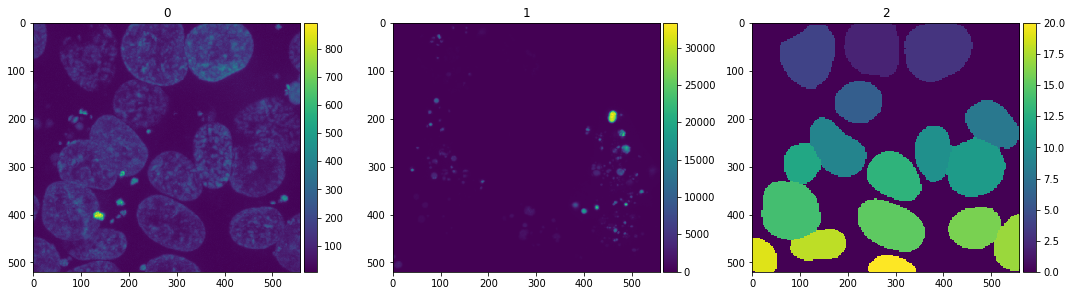

In [6]:
#################################
#  Don't modify the code below  #
#################################

if sample_index is None:
    sample_index = np.random.randint(len(samples))
    
sample = samples[sample_index]
dataset = intake_io.imload(sample)
print(dataset, '\n')
if 'c' in dataset.dims:
    nchannels = len(dataset['c'].data)
else:
    nchannels = 1
if roi_segmentation:
    nchannels -= 1
print(rf"Number of channels: {nchannels}")

show_dataset(dataset)

<hr style="height:0.5px;">

### Please specify the indices of puncta channels and the channel to set up


`puncta_channels` : list of channel indices, starting form 0, that should be used to segment puncta. 

**Examples**:

`puncta_channels = [1]` : puncta will be segmented in the second channel

`puncta_channels = [2, 3]` : puncta will be segmented in the third and fourth channels


In [7]:
puncta_channels = [1]

### The following code displays the puncta channels and the nuclei segmentation of the current image

Current number of z layers: 36


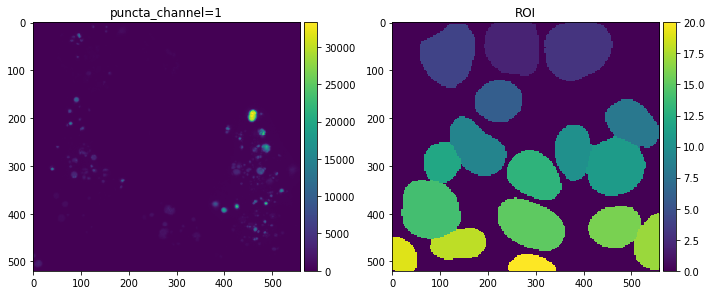

In [8]:
#################################
#  Don't modify the code below  #
#################################

if 'z' in dataset.dims:
    print(rf'Current number of z layers: {len(dataset["z"].data)}')
else:
    print('No z layers were found, the dataset is 2D')
    
channel_names = [rf"puncta_channel={i}" for i in puncta_channels]
    
if roi_segmentation:
    show_dataset(dataset, puncta_channels + [-1], channel_names + ['ROI'])
else:
    show_dataset(dataset, puncta_channels, channel_names)
    

### Please select a small box to test the analysis:

Keep the width and height 200 - 500 pixels.

To used the entire image, set x, y, z, width, height and depth to `None`

In [9]:
x = 350    # coordinate of the left border
y = 150   # coordinate of the top border
z = 10
width = 300   # width of the box
height = 300  # height of the box
depth = 40

# x = 100    # coordinate of the left border
# y = 100   # coordinate of the top border
# z = 10
# width = 300   # width of the box
# height = 300  # height of the box
# depth = 40

### The following code crops the dataset and displays the cropped area:

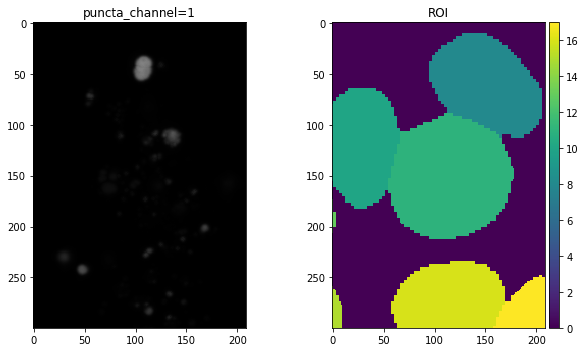

In [10]:
#################################
#  Don't modify the code below  #
#################################

ds_crop = crop_dataset(dataset, x, y, z, width, height, depth)

if roi_segmentation:
    show_dataset(ds_crop, puncta_channels + [-1], channel_names + ['ROI'])
else:
    show_dataset(ds_crop, puncta_channels, channel_names)

In [11]:
spacing = np.array(intake_io.get_spacing(dataset))
if 'c' in ds_crop.dims:
    chnames = ds_crop['c'].data
else:
    chnames = [0]
img = ds_crop.loc[dict(c=chnames[puncta_channels[0]])]['image'].data
roi = ds_crop.loc[dict(c=chnames[-1])]['image'].data

_______________

In [12]:
# frequent:
minsize_um = 0.2  
maxsize_um = 2.
threshold_detection = 0.001

# advanced:
num_sigma = 5
overlap = 1

In [13]:
logblobs = blob_log(img,
                    min_sigma=minsize_um / spacing,
                    max_sigma=maxsize_um / spacing,
                    num_sigma=int(num_sigma),
                    overlap=overlap,
                    threshold=threshold_detection)

In [14]:
ds_log = ds_crop.copy(deep=True)

In [15]:
log_filt = filter_laplace(img, minsize_um, maxsize_um, int(num_sigma), spacing) 
ds_log['image'].loc[dict(c=chnames[puncta_channels[0]])] = log_filt

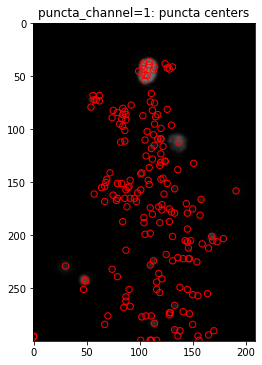

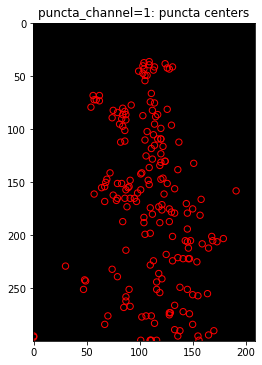

In [16]:
display_blobs(ds_crop, [logblobs[:, :int(logblobs.shape[1]/2)]], 
              puncta_channels, channel_names, 'puncta centers')

display_blobs(ds_log, [logblobs[:, :int(logblobs.shape[1]/2)]], 
              puncta_channels, channel_names, 'puncta centers')

In [17]:
def filter_laplace2(img, minsize_um, maxsize_um, num_sigma, spacing):
    laplace = np.zeros(img.shape, dtype=np.float32)
    for sigma in np.linspace(minsize_um/spacing, maxsize_um/spacing, int(num_sigma), endpoint=True):
        laplace = np.max(np.stack([laplace, -ndimage.gaussian_laplace(img*1., sigma)]), axis=0)

    return laplace

In [18]:
%%time
img = img * 1. / np.max(img)

CPU times: user 6.82 ms, sys: 0 ns, total: 6.82 ms
Wall time: 6.58 ms


In [19]:
sigma = 0.5/spacing
sigma

array([2.5      , 4.5454545, 4.5454545])

In [20]:
%%time
scales = [0.2, 0.5, 1, 1.5, 2.]
sigmas = [s/spacing for s in scales]
lps = [-ndimage.gaussian_laplace(img*1., sigma)*np.mean(sigma)**2 for sigma in sigmas]
lps = [np.clip(lp, 0, None) for lp in lps]

CPU times: user 2.76 s, sys: 34.5 ms, total: 2.79 s
Wall time: 2.8 s


/research/sharedresources/cbi/public/conda_envs/punctatools/lib/python3.9/site-packages/scikit_image-0.19.0-py3.9-linux-x86_64.egg/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


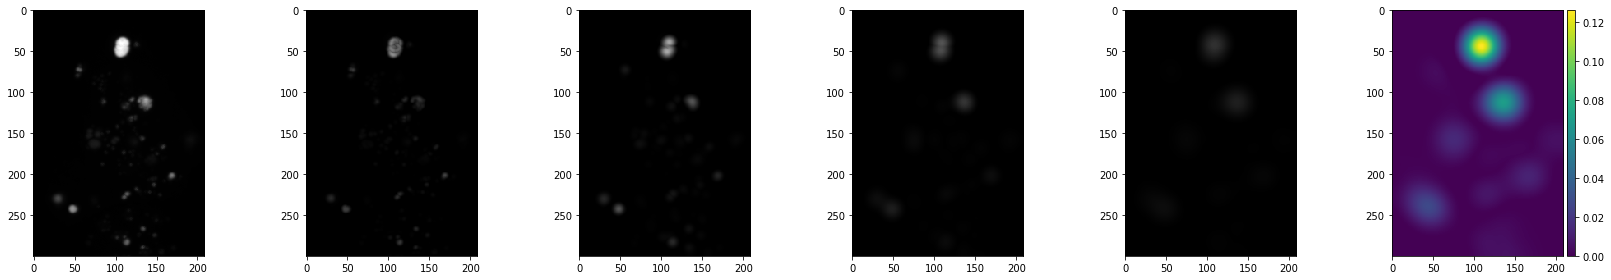

In [21]:
show_imgs([img] + lps)

In [22]:
peaks = [feature.peak_local_max(lp, 
                                # min_distance=int(round(sigma[0])),
                                threshold_abs=0) for lp in lps]   #, min_distance=int(round(sigma[0])))

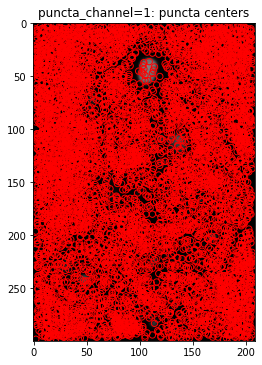

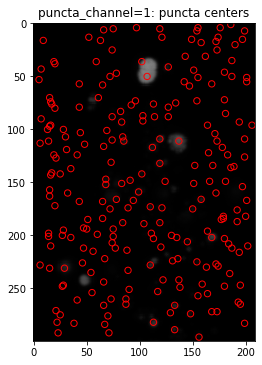

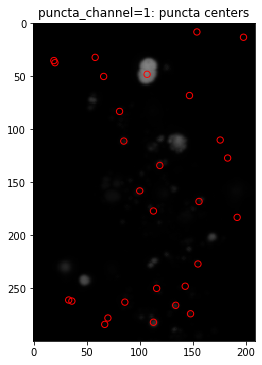

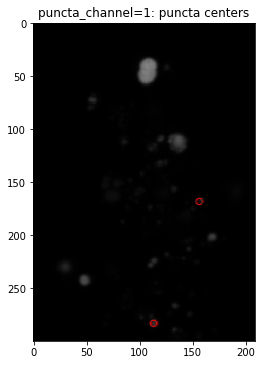

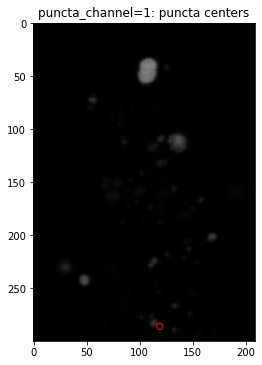

In [23]:
for p in peaks:
    display_blobs(ds_crop, [p], 
              puncta_channels, channel_names, 'puncta centers')

In [24]:
def segment_blobs(lp, p, roi, scale, sigma, spacing, r1=0.6, r2=3., bg_thr=10):
    # create a labeled maxima image
    p_label = np.zeros(lp.shape)
    p_label[tuple(p.transpose())] = 1
    p_label = ndimage.label(p_label)[0]

    # calculate distance transform and voronoi diagram
    dist = ndimage.distance_transform_edt(p_label==0, sampling=spacing)
    vor = watershed(dist, markers=p_label)
    
    # calculate ROI-wise background  
    roi_llist = np.unique(roi)
    roi_bg = (dist > r2*scale) * roi  # only consider pixels r2 away from the centers
    roi_bg_val = ndimage.mean(lp, roi_bg, roi_llist)
    roi_bg = map_array(roi_bg, roi_llist, roi_bg_val)
    
    # remove peaks with low intensity relative to the ROI background
    fg = (dist < r1*scale) * vor # foreground intensity image
    llist = np.unique(vor) # unique center values
    fg_int = ndimage.mean(lp, fg, llist) # foreground intensity values
    bg_int = ndimage.mean(roi_bg, fg, llist) # background intensity values   
    p_label[np.in1d(p_label.ravel(), 
                     llist[(fg_int/bg_int < bg_thr)]).reshape(p_label.shape)] = 0 # remove peaks with low values
    
    # recalculate distance transform and voronoi diagram
    dist = ndimage.distance_transform_edt(p_label==0, sampling=spacing)
    vor = watershed(dist, markers=p_label)
    
    # calculate local threshold values
    fg = (dist < r1*scale) * vor # labeled foreground image (within radius r1)
    bg = (dist > r1*scale) * (dist < r2*scale) * vor # labeled background image (between radii r1 and r2)
    llist = np.unique(vor) # updated unique center values
    fg_int = ndimage.mean(lp, fg, llist) # foreground intensity values
    bg_int = ndimage.mean(lp, bg, llist) # background intensity values   
    thr = (fg_int + bg_int) / 2 # threshold values
    
    # map threshold values onto the Voronoi regions
    thr_img = map_array(vor, llist, thr)
    
    # threshold the image
    mask = (lp > thr_img)*(dist < r2*scale)*vor
    return mask

In [25]:
%%time
masks = [segment_blobs(lps[i], peaks[i], roi, scales[i], sigmas[i], 
                       spacing, r1=0.6, r2=3., bg_thr=15) 
         for i in tqdm(range(len(scales)))]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.35s/it]

CPU times: user 6.61 s, sys: 124 ms, total: 6.73 s
Wall time: 6.75 s


/research/sharedresources/cbi/public/conda_envs/punctatools/lib/python3.9/site-packages/scikit_image-0.19.0-py3.9-linux-x86_64.egg/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


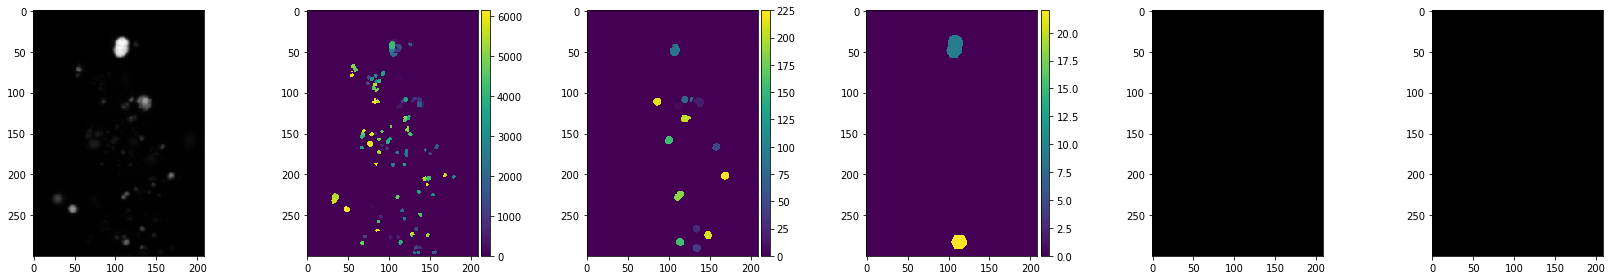

In [26]:
show_imgs([img] + masks)

In [27]:
lpimg = img.max(0) / img.max(0).max()
lpimg.max()

1.0

In [28]:
for mask, color in zip(masks, [(1,0,0), (0,1,0), (0,0,1), (1,1,0), (1,0,1)]):
    lpimg = mark_boundaries(lpimg, mask.max(0), color=color)

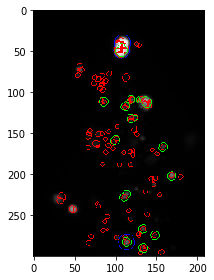

In [29]:
io.imshow(lpimg)